In [1]:
# imports

import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import urllib.request
import ptb_iterator as reader

In [2]:
# load and process data

file_url = 'https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt'
file_name = 'tinyshakespeare.txt'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)

with open(file_name, 'r') as f:
    raw_data = f.read()
    print('Data lenght: {} bytes'.format(len(raw_data)))

vocab = set(raw_data)
vocab_size = len(vocab)
idx_to_vocab = dict(enumerate(vocab))
vocab_to_idx = dict(zip(idx_to_vocab.values(), idx_to_vocab.keys()))

data = [vocab_to_idx[c] for c in raw_data]
del raw_data

Data lenght: 1115394 bytes


In [3]:
# utility functions

def gen_epochs(n, num_steps, batch_size):
    for i in range(n):
        yield reader.ptb_iterator(data, batch_size, num_steps)

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def train_network(g, num_epochs, num_steps = 200, batch_size = 32, verbose = True, save = False):
    tf.set_random_seed(2345)

    with tf.Session() as sess:
        # TODO: try to restore the graph
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, batch_size)):
            training_loss = 0
            steps = 0
            training_state = None
            
            for X, Y in epoch:
                # workaround to avoid mis-shaped inputs
                if X.shape[1] != num_steps or Y.shape[1] != num_steps:
                    continue
                steps += 1
                feed_dict = {g['x']: X, g['y']: Y}
                if training_state is not None:
                    feed_dict[g['init_state']] = training_state
                training_loss_, training_state, _ = \
                    sess.run([g['total_loss'], g['final_state'], g['train_step']], feed_dict)
                training_loss += training_loss_

            if verbose:
                print('avg training loss for epoch {0}: {1:.4f}'.format(idx, training_loss/steps))
            
            training_losses.append(training_loss/steps)
        
        # I hate dynamic typing....
        if isinstance(save, str):
            g['saver'].save(sess, save)

    return training_losses

In [4]:
def build_multilayer_lstm_graph_with_dynamic_rnn(
        state_size=100, num_classes=vocab_size, batch_size=32,
        num_steps=200, num_layers=3, learning_rate=1e-4):
    reset_graph()
    
    x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')

    embeddings = tf.get_variable('embedding_matrix', [num_classes, state_size])
    
    # our inputs now is a tensor of dims batch_size x num_steps x state_size
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)
    
    lstm_cells = [tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True) for _ in range(num_layers)]
    cell = tf.contrib.rnn.MultiRNNCell(lstm_cells, state_is_tuple=True)
    init_state = cell.zero_state(batch_size, tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    
    # reshape rnn outputs and y so we can get the logits in a single matmul
    rnn_outputs = tf.reshape(rnn_outputs, [-1, state_size])
    y_reshaped = tf.reshape(y, [-1])
    
    logits = tf.matmul(rnn_outputs, W) + b
    
    predictions = tf.nn.softmax(logits)
    
    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    
    return dict(x = x, y = y, init_state = init_state, final_state = final_state,
                total_loss = total_loss, train_step = train_step,
                preds = predictions, saver = tf.train.Saver())

avg training loss for epoch 0: 3.4104
avg training loss for epoch 1: 3.2817
avg training loss for epoch 2: 3.0693
avg training loss for epoch 3: 2.8437
avg training loss for epoch 4: 2.7204
avg training loss for epoch 5: 2.6481
avg training loss for epoch 6: 2.5849
avg training loss for epoch 7: 2.4803
avg training loss for epoch 8: 2.4098
avg training loss for epoch 9: 2.3612
avg training loss for epoch 10: 2.3184
avg training loss for epoch 11: 2.2840
avg training loss for epoch 12: 2.2545
avg training loss for epoch 13: 2.2274
avg training loss for epoch 14: 2.2023
avg training loss for epoch 15: 2.1785
avg training loss for epoch 16: 2.1562
avg training loss for epoch 17: 2.1354
avg training loss for epoch 18: 2.1157
avg training loss for epoch 19: 2.0972
It took 908.5327310562134 seconds to build and train the RNN


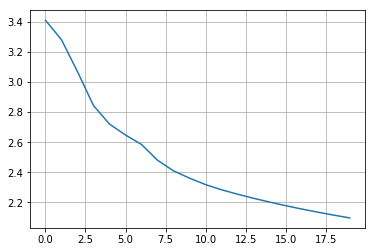

In [5]:
t = time.time()
g = build_multilayer_lstm_graph_with_dynamic_rnn(num_steps=80)
losses = train_network(g, num_epochs=20, num_steps=80, save='checkpoints/LSTM_20e_80s')
print('It took {} seconds to build and train the RNN'.format(time.time() - t))
plt.plot(losses)
plt.grid()

## Generating text

In [13]:
def generate_characters(g, checkpoint, num_chars, prompt='A', pick_top_chars=None):
    with tf.Session() as sess:
        g['saver'].restore(sess, checkpoint)
        
        state = None
        current_char = vocab_to_idx[prompt]
        chars = [current_char]
        
        for i in range(num_chars):
            if state is not None:
                feed_dict = {g['x']: [[current_char]], g['init_state']: state}
            else:
                feed_dict = {g['x']: [[current_char]]}
            
            preds, state = sess.run([g['preds'], g['final_state']], feed_dict)
            
            p = np.squeeze(preds)

            if pick_top_chars is not None:
                p[np.argsort(p)[:-pick_top_chars]] = 0
                p = p / np.sum(p)

            current_char = np.random.choice(vocab_size, 1, p=p)[0]
            
            chars.append(current_char)

    chars = map(lambda x: idx_to_vocab[x], chars)
    return "".join(chars)

In [14]:
g = build_multilayer_lstm_graph_with_dynamic_rnn(num_steps=1, batch_size=1)
print(generate_characters(g, 'checkpoints/LSTM_20e_80s', 750, prompt='A', pick_top_chars=5))

INFO:tensorflow:Restoring parameters from checkpoints/LSTM_20e_80s
A
diyng a dasger tit more.

GATISS:
A ant and at met afle the shealnss,
Son sall the thandesed son or thor the hang
And wite he met thar and me mins o the beet.

PUCIO:
Whit hor hens so peart so to the mither weer
And the thonting sont the sreeles series
I'd whoule, the theath ant myon sen the hert
Tare so misher here and that afd sall.

KUNE HIRD VODK::
Ill misher ans thal the wite a muves to word
And mich senters, will this tourder and thath tire
Af a so thou shas have thou hearth met the the thous.

GUCIO EORGERE:
And shathe aftised he be will at to have.

LORTENGE:
A thee thil this, to hors hing at and warlied.

POLTOO:
Whiy the seor of af to have so pould. Wint ant the wend worle
And thyer hard orfer there and thou houd tone,
Of heard m
